In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [97]:
cols = list(range(1,785))

In [98]:
train_data = pd.read_csv("TrainData.csv",sep=" ",header=0,names=cols)
train_labels = pd.read_csv("TrainLabels.csv",header=0,names=[1])
test_data = pd.read_csv("TestData.csv",sep=" ",header=0,names=cols)


In [148]:
from skimage import feature

In [196]:
location

5894

# Now Visualizing the Train Data

In [99]:
train_data.shape

(11999, 784)

In [100]:
train_labels.shape

(11999, 1)

In [101]:
test_data.shape

(1999, 784)

array([[<AxesSubplot:title={'center':'1'}>]], dtype=object)

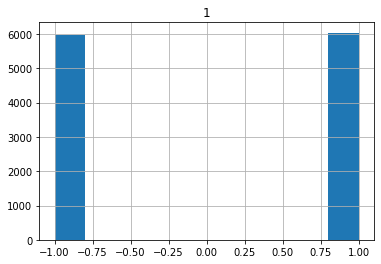

In [102]:
train_labels.hist()
#Almost equal classes

In [103]:
sum(train_data.isnull().sum())
#NO Null Values

0

[1.]


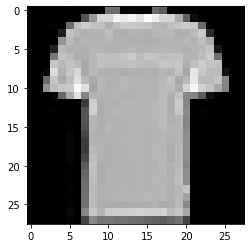

In [104]:
import random
import math

location = math.floor(random.random()*11999)
plt.imshow(train_data.loc[location,:].values.reshape(28,28),cmap="gray")
print(train_labels.loc[location,:].values)


## Finding 0 pixel value counts throughout the dataframe

In [105]:
def isblank(x):
    return x==0
zero_vals = train_data.applymap(isblank)

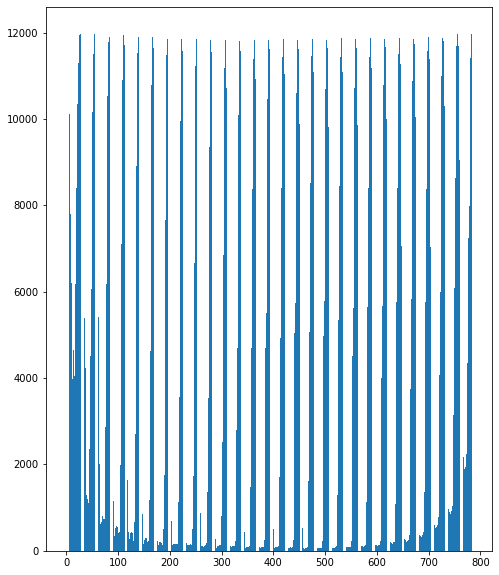

In [106]:
zero_vals_sum = zero_vals.sum().reset_index()
plt.figure(figsize=(8,10))
plt.bar(zero_vals_sum.index, zero_vals_sum[0])
plt.show()

### It looks like many features have most values equal to zero. We can use the transformation and feature extraction techniques to either remove these features or reduce our feature size

# Feature Extraction
## Different Feature Extractors and their results

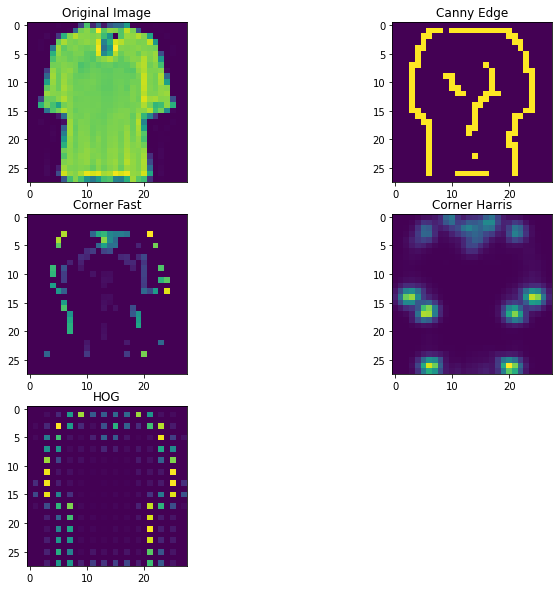

In [205]:
location = math.floor(random.random()*11999)

image = train_data.loc[location,:].values.reshape(28,28)
canny = feature.canny(image, sigma=2)
cornerfast = feature.corner_fast(image,n=12)
cornerharris = feature.corner_harris(image,method='eps',eps=3e-10)
fd,hog_img = hog(image, orientations=4, pixels_per_cell=(2, 2),
                                cells_per_block=(10, 10), visualize=True,transform_sqrt=True)

plt.figure(figsize=(12,10))
plt.subplot(3,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(3,2,2)
plt.imshow(canny)
plt.title("Canny Edge")
plt.subplot(3,2,3)
plt.imshow(cornerfast)
plt.title("Corner Fast")
plt.subplot(3,2,4)
plt.imshow(cornerharris)
plt.title("Corner Harris")
plt.subplot(3,2,5)
plt.imshow(hog_img)
plt.title("HOG")
plt.show()

# HOG and Canny Edge Filters are good for the fact that they give an outside boundary and provide good features. Drawback with Canny Edge Filters is, it only provides boolean information which may or may not be helpful

# Corner Harris is also good as it gives sleeve edges that may be a good factor in deciding the class of shirt

# Creating Functions for HOG, Canny Edge and Corner Harris

In [208]:
#Create Hog
import matplotlib.pyplot as plt
from skimage.feature import hog,canny,corner_harris
from skimage import data, exposure
from PIL import Image
import pickle

In [287]:
def get_hog(readsaved=1,train_data = None):
    final_train_data = []
    if(readsaved):
        with open('hog_features.pickle', 'rb') as handle:
            final_train_data = pickle.load(handle)
        return np.array(final_train_data)
    else:
        if(train_data.empty):
            print("Error. Train Data...")
            return
        for location in range(0,11999):

            X = train_data.loc[location,:].values.reshape(28,28)
            fd,hog_img = hog(X, orientations=4, pixels_per_cell=(2, 2),
                                cells_per_block=(1, 1), visualize=True,transform_sqrt=True)

            final_train_data.append([fd,exposure.rescale_intensity(hog_img, in_range=(0, 10))])
        with open('hog_features.pickle', 'wb') as handle:
            pickle.dump(final_train_data,handle)
        return np.array(final_train_data)

In [288]:
def get_corner_harris(readsaved=1,train_data = None):
    final_train_data = []
    if(readsaved):
        with open('corner_harris.pickle', 'rb') as handle:
            final_train_data = pickle.load(handle)
        return np.array(final_train_data)
    else:
        if(train_data.empty):
            print("Error. Train Data...")
            return
        for location in range(0,11999):

            X = train_data.loc[location,:].values.reshape(28,28)
            fd = corner_harris(X,method='eps',eps=3e-10)
            fd_feature = fd.flatten()

            final_train_data.append([fd_feature,fd])
        with open('corner_harris.pickle', 'wb') as handle:
            pickle.dump(final_train_data,handle)
        return np.array(final_train_data)

In [289]:
def get_canny(readsaved=1,train_data = None):
    final_train_data = []
    if(readsaved):
        with open('canny_features.pickle', 'rb') as handle:
            final_train_data = pickle.load(handle)
        return np.array(final_train_data)
    else:
        if(train_data.empty):
            print("Error. Train Data...")
            return
        for location in range(0,11999):

            X = train_data.loc[location,:].values.reshape(28,28)
            fd = canny(X,sigma=3)
            fd_feature = fd.flatten()

            final_train_data.append([fd_feature,fd])
        with open('canny_features.pickle', 'wb') as handle:
            pickle.dump(final_train_data,handle)
        return np.array(final_train_data)

In [290]:
def convert_to_df(final_train_data):
    cols = list(range(1,train_data.shape[1]+1))
    fd_data = [h[0] for h in final_train_data]
    fd_dataframe = pd.DataFrame(fd_data,columns=cols)
    return fd_dataframe

def feature_scaling(dataframe):
    scaler=StandardScaler()
    scaler.fit(dataframe)
    scaled_data=scaler.transform(dataframe)
    return scaled_data

# Feature Selection

In [291]:
def dimensionality_reduction(scaled_data=None,n_components=550):
    from sklearn.decomposition import PCA
    pca=PCA(n_components=n_components,
           whiten=True)
    pca.fit_transform(scaled_data)
    variance = pca.explained_variance_ratio_
    variance = np.cumsum(np.round(variance,decimals=3)*100)
    plt.plot(variance)
    plt.grid()
    plt.title("Number of Features vs. Explained Variance")
    plt.xlabel("Number of Features")
    plt.ylabel("CDF of Explained Variance")
    print(max(variance))
    x_pca=pca.transform(scaled_data)
    return x_pca


In [292]:
hog_features = get_hog(readsaved=1,train_data =train_data)
canny_features = get_canny(readsaved=1,train_data=train_data)
corner_harris_features = get_corner_harris(readsaved=1,train_data=train_data)

In [293]:
hog_feats_df = convert_to_df(hog_features)
canny_features_df = convert_to_df(canny_features)
corner_harris_df  = convert_to_df(corner_harris_features)

In [295]:
hog_feats_df_fs = feature_scaling(hog_feats_df)
canny_feats_df_fs = feature_scaling(canny_features_df)
corner_harris_df_fs  = feature_scaling(corner_harris_df)

96.6999999999985


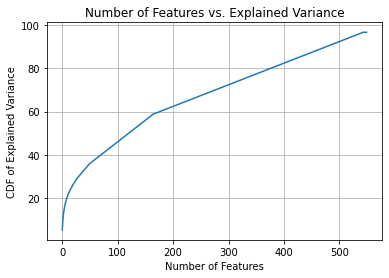

In [296]:
hog_pca_feats = dimensionality_reduction(hog_feats_df_fs,n_components=550)

93.999999999999


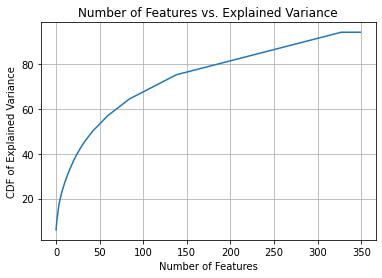

In [299]:
canny_pca_feats = dimensionality_reduction(canny_feats_df_fs,n_components=350)

97.4999999999997


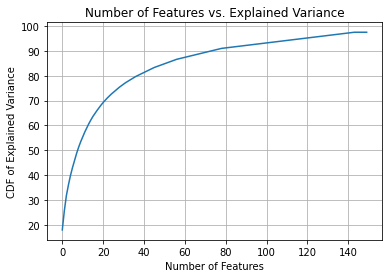

In [300]:
cornerharris_pca_feats = dimensionality_reduction(corner_harris_df_fs,n_components=150)

# Running Models

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

def run_cv(X,y,model=None,n_splits=10,test_size=0.3,random_state = 100):
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    score1 = cross_validate(model,X,y,cv=cv,scoring=['accuracy'],return_train_score=True,return_estimator=True)
    plt.plot(score1["test_accuracy"],scaley=True)
    plt.grid()
    plt.title("Accuracy vs. CV Run Chart")
    plt.xlabel("CV Split")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    
    return score1

def plot_curves(model,X,y,n_splits=10,test_size=0.3,random_state = 100):
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, X, y, cv=cv, n_jobs=2, return_times=True)
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    plt.show()

In [302]:
hog_X = hog_pca_feats
canny_X = canny_pca_feats
corner_X = cornerharris_pca_feats
y = train_labels[1].ravel()


In [303]:
seed_data = int(random.random()*11999)

# Logistic Regression

In [304]:
from sklearn.linear_model import LogisticRegression
logisticmodel = LogisticRegression(
    max_iter=16000,
    C=5e-2,
    penalty="l2",
    solver="liblinear",
    multi_class="ovr"
    )

In [305]:
def logisticreg(logisticmodel,X,y,cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_data)
    logisticmodel.fit(X_train,y_train)
    y_score = logisticmodel.predict(X_test) 
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    score_logistic = run_cv(X,y,logisticmodel,cv,0.3,seed_data)
    plot_curves(logisticmodel,X,y,cv,0.3,seed_data)

===Hog Model====
Average precision-recall score: 0.73


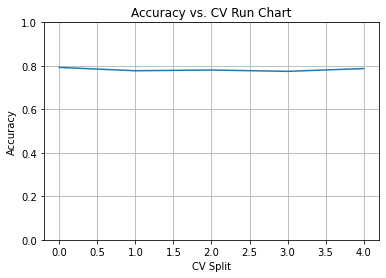

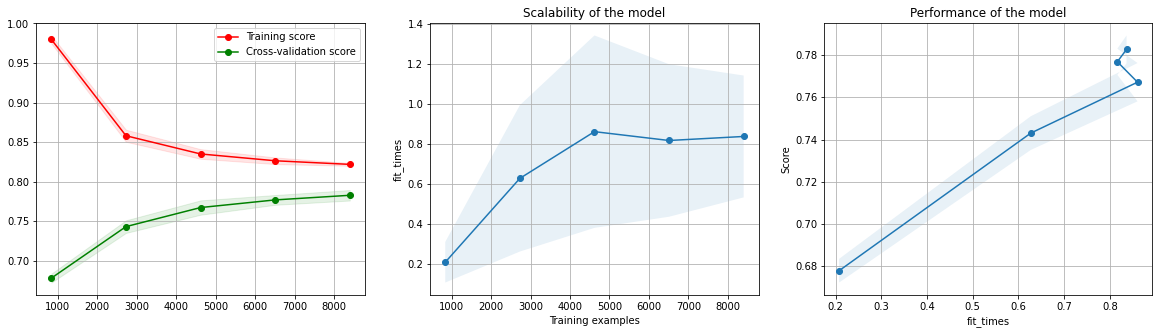

===Canny Model====
Average precision-recall score: 0.70


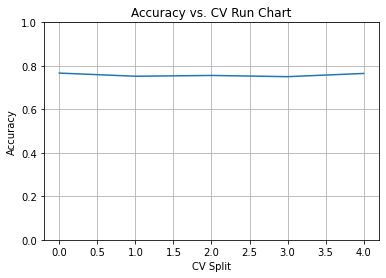

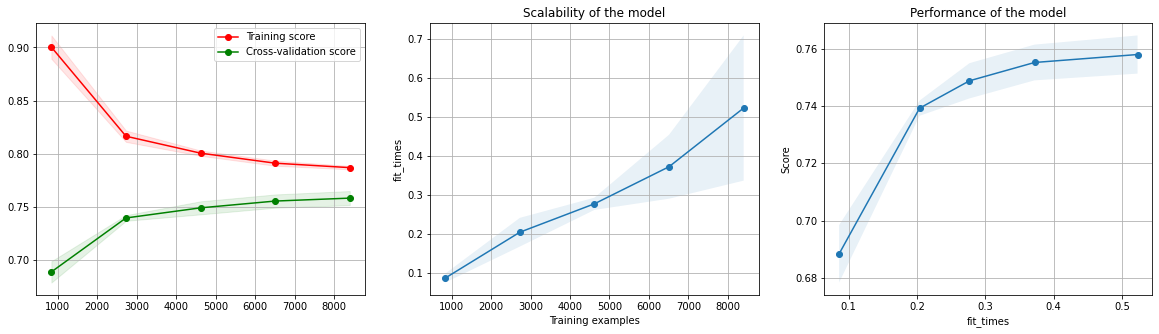

===Canny Model====
Average precision-recall score: 0.72


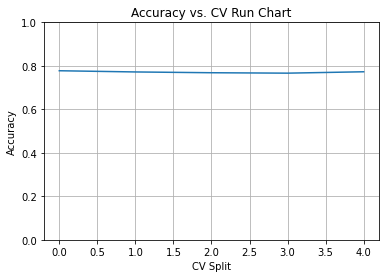

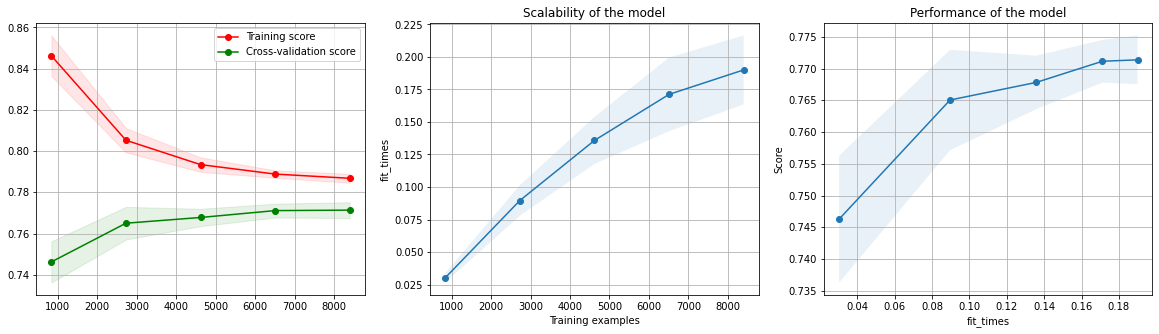

In [306]:
print("===Hog Model====")
logisticreg(logisticmodel,hog_X,y,cv=5)
print("===Canny Model====")
logisticreg(logisticmodel,canny_X,y,cv=5)
print("===Corner Model====")
logisticreg(logisticmodel,corner_X,y,cv=5)


# SVM

In [337]:
from sklearn import svm
svmmodel = svm.SVC(
    kernel='rbf',
    max_iter=4000,
    C=12)

In [313]:
from sklearn.metrics import average_precision_score

def svm_model(svmmodel,X,y,cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_data)
    svmmodel.fit(X_train,y_train)
    y_score = svmmodel.decision_function(X_test)    
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    score_svm = run_cv(X,y,svmmodel,cv,0.3,seed_data)
    plot_curves(svmmodel,X,y,cv,0.3,seed_data)
    print(score_svm["test_accuracy"])

In [312]:
print("===Hog Model====")
svm_model(svmmodel,hog_X,y,cv=5)
print("===Canny Model====")
svm_model(svmmodel,canny_X,y,cv=5)
print("===Corner Model====")
svm_model(svmmodel,corner_X,y,cv=5)

===Hog Model====
Average precision-recall score: 0.84
===Canny Model====
Average precision-recall score: 0.79
===Corner Model====
Average precision-recall score: 0.83


In [339]:
run_cv(hog_X,y,svmmodel,5,0.3,seed_data)

KeyboardInterrupt: 

# K-Nearest Neighbors

The k is selected by formula: 

## $k=\sqrt{n}/2$ 

### Where n = number of samples. 

In [315]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=28,)

In [324]:
def knn_model(knn,X,y,cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_data)
    knn.fit(X_train,y_train)
    y_score = knn.predict(X_test)    
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
#     score_svm = run_cv(X,y,knn,cv,0.3,seed_data)
#     plot_curves(knn,X,y,cv,0.3,seed_data)
#     print(score_svm["test_accuracy"])

In [325]:
knn_model(knn,hog_X,y,5)

Average precision-recall score: 0.52


In [326]:
knn_model(knn,canny_X,y,5)

Average precision-recall score: 0.59


In [327]:
knn_model(knn,corner_X,y,5)

Average precision-recall score: 0.71


# Random Forest Classifier

In [80]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(max_depth=2, random_state=0)

In [329]:
def randomforest_model(randomforest,X,y,cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_data)
    randomforest.fit(X_train,y_train)
    y_score = randomforest.predict(X_test)    
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
#     score_svm = run_cv(X,y,knn,cv,0.3,seed_data)
#     plot_curves(knn,X,y,cv,0.3,seed_data)
#     print(score_svm["test_accuracy"])

In [331]:
randomforest_model(randomforest,hog_X,y,5)

Average precision-recall score: 0.69


In [332]:
randomforest_model(randomforest,canny_X,y,5)

Average precision-recall score: 0.68


In [333]:
randomforest_model(randomforest,corner_X,y,5)

Average precision-recall score: 0.69


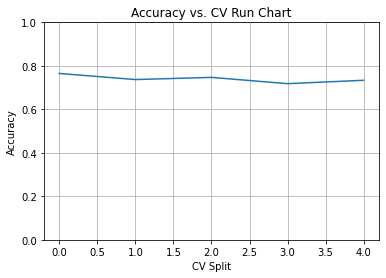

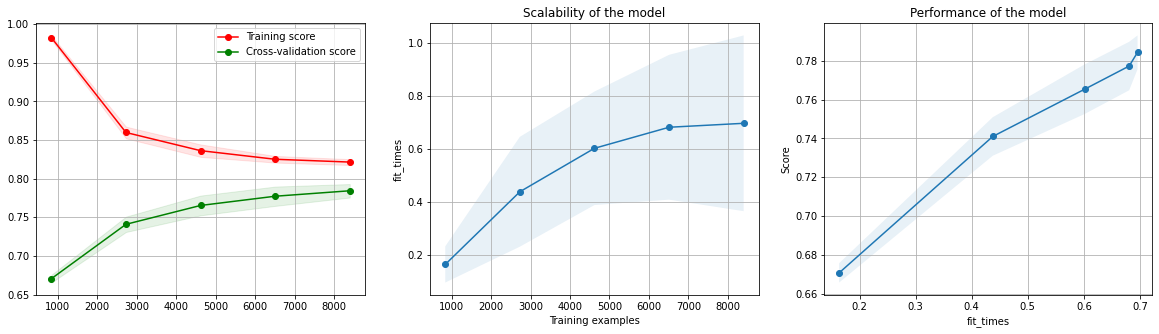

In [81]:
score_randomforest = run_cv(Hog_X,y,randomforest,5,0.3,seed_data)
plot_curves(randomforest,Hog_X,y,5,0.3,seed_data)

# SVM Model Finalization

## Hog Estimators used

In [350]:
from sklearn import svm
svmmodel = svm.SVC(
    kernel='rbf',
    max_iter=4000,
    C=12)

In [351]:
svmmodel.fit(hog_X,y)

SVC(C=12, max_iter=4000)

In [352]:
from joblib import dump, load
dump(svmmodel, 'svm_model.joblib') 

['svm_model.joblib']

# Re-loading the model and testing

In [353]:
model = load('svm_model.joblib') 

96.5999999999985


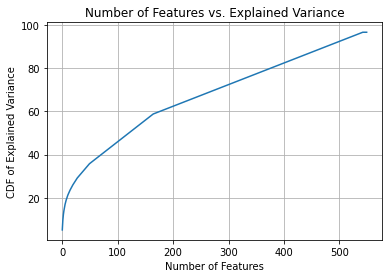

In [356]:
test_hog_features = get_hog(readsaved=1,train_data =test_data)
test_hog_feats_df = convert_to_df(hog_features)
test_hog_feats_df_fs = feature_scaling(hog_feats_df)
test_hog_pca_feats = dimensionality_reduction(test_hog_feats_df_fs,n_components=550)

predicted_values = model.predict(test_hog_pca_feats)

In [365]:
np.savetxt("myPredictions.csv", predicted_values)

# Random Sample Testing

In [362]:
predicted_values[56]

-1.0

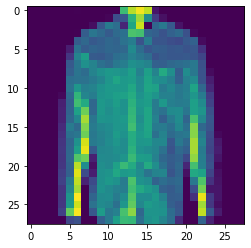

In [363]:
location=56
image = train_data.loc[location,:].values.reshape(28,28)
plt.imshow(image)